# Машинное обучение ИБ-2024

# Домашнее задание 3.
# Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [1]:
import numpy as np
import pandas as pd
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vanya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vanya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv("combined_data.csv")
df.rename(columns={"label": "target"}, inplace=True)
df.head()

,target,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str) -> str:
    text = text.lower()  # приведение к нижнему регистру
    text = re.sub(r'[^a-z\s]', '', text)  # удаление пунктуации и чисел
    tokens = word_tokenize(text)  # токенизация
    tokens = [t for t in tokens if t not in stop_words and t.strip() != '']  # удаление стоп-слов
    # лемматизация текста, приведение слов к словарной начальной форме, например dogs -> dog, running -> run
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)  # объединение обратно в строку

In [4]:
df['text'] = df['text'].apply(preprocess_text)
df.head()

,target,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain prosperous future mon...
4,0,thanks answer guy know checked rsync manual wo...


In [5]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train

6030     mumia w wrote escapenumber escapenumber escape...
75166    oh dear sir throat much better hardly mr westo...
69800    many victim con telemarketing scam retail con ...
78123    hello best erection drug world wide shiping vi...
39904    may escapenumber escapenumber home u world pol...
                               ...                        
18630    hewlett packardpavilion notebook specialfor ar...
18711    howstuffworks r automotive may escapenumber es...
63095    attached please find interview packet referenc...
67174    sorry dont think linux mold kernel computer un...
43524    doubt short silence formed bauxite issue innoc...
Name: text, Length: 66758, dtype: object

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

def search_params(model, param_grid, X_train, y_train):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=3
    )
    grid.fit(X_train, y_train)
    return grid

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

def get_model_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None



    metrics = {
        "Model": model_name,
        "Accuracy": f"{acc:.4f}",
        "Precision": f"{prec:.4f}",
        "Recall": f"{rec:.4f}",
        "F1-Score": f"{f1:.4f}"
    }

    if roc is not None:
        metrics["ROC-AUC"] = f"{roc:.4f}"

    print(
        tabulate(
                [metrics.values()],
                headers=metrics.keys(),
                tablefmt="github"
            )
        )

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# BoW

Bag of Words (BoW) это простой способ для генерации текстовых эмбеддингов. Создается список уникальных слов в корпусе и для каждого текста считается количество вхождений каждого из этих слов в него. В итоге мы получаем набор числовых признаков которые можно скормить модельке.

In [9]:
lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}
lr_grid_bow = search_params(LogisticRegression(random_state=42), lr_params, X_train_bow, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
rf_grid_bow = search_params(RandomForestClassifier(random_state=42), rf_params, X_train_bow, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [11]:
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}
xgb_grid_bow = search_params(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_bow, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [23:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| Model    |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|----------|------------|-------------|----------|------------|-----------|
| LR (BoW) |     0.9845 |      0.9814 |   0.9894 |     0.9854 |     0.997 |


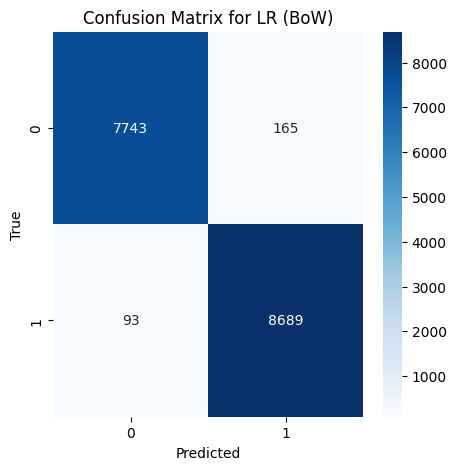

In [12]:
best_lr_bow = lr_grid_bow.best_estimator_
get_model_metrics(best_lr_bow, X_test_bow, y_test, "LR (BoW)")

| Model              |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|--------------------|------------|-------------|----------|------------|-----------|
| RandomForest (BoW) |     0.9799 |       0.989 |   0.9726 |     0.9807 |     0.998 |


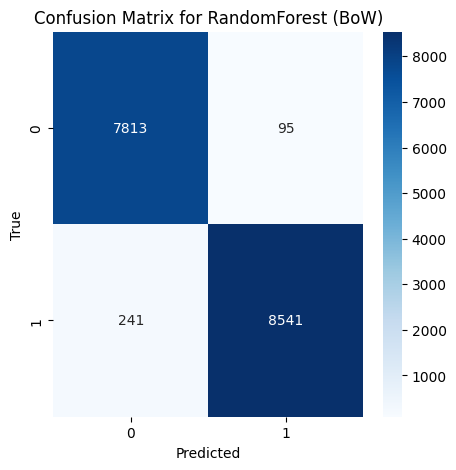

In [13]:
best_rf_bow = rf_grid_bow.best_estimator_
get_model_metrics(best_rf_bow, X_test_bow, y_test, "RandomForest (BoW)")

| Model         |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|---------------|------------|-------------|----------|------------|-----------|
| XGBoost (BoW) |     0.9756 |      0.9653 |   0.9892 |     0.9771 |     0.997 |


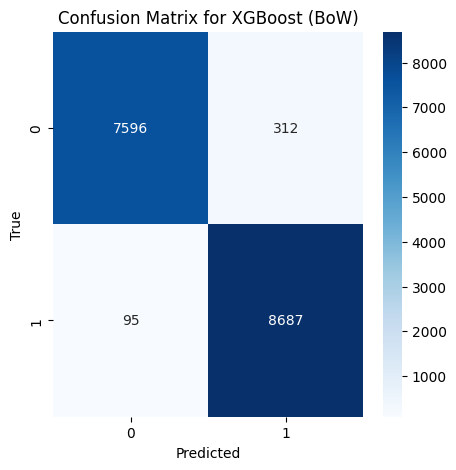

In [14]:
best_xgb_bow = xgb_grid_bow.best_estimator_
get_model_metrics(best_xgb_bow, X_test_bow, y_test, "XGBoost (BoW)")

# TF-IDF

TF-IDF — это чуть более продвинутый метод генерации текстовых эмбеддингов. Теперь мы считаем количество вхождений слов и их "вес" в тексте и всем корпусе. Редкие но значимые слова получают больший вес, а часто встречающиеся и "водянистые" меньший. В итоге мы получаем более осмысленные числовые эмбеддинги которые лучше помогают модели отличать ключевые слова от "воды".

In [15]:
lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}
lr_grid_tfidf = search_params(LogisticRegression(random_state=42), lr_params, X_train_tfidf, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [16]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
rf_grid_tfidf = search_params(RandomForestClassifier(random_state=42), rf_params, X_train_tfidf, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [17]:
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}
xgb_grid_tfidf = search_params(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_tfidf, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\vanya\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [23:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


| Model       |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|-------------|------------|-------------|----------|------------|-----------|
| LR (TF-IDF) |     0.9881 |      0.9854 |    0.992 |     0.9887 |    0.9988 |


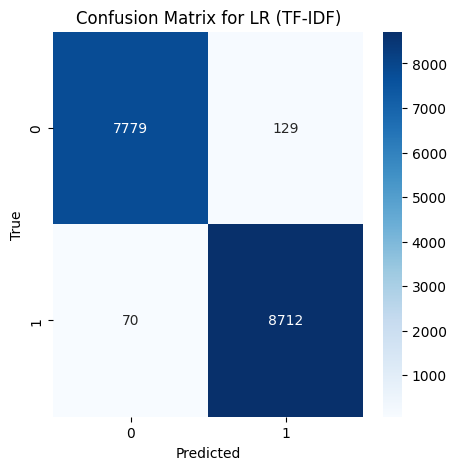

In [18]:
best_lr_tfidf = lr_grid_tfidf.best_estimator_
get_model_metrics(best_lr_tfidf, X_test_tfidf, y_test, "LR (TF-IDF)")

| Model                 |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|-----------------------|------------|-------------|----------|------------|-----------|
| RandomForest (TF-IDF) |     0.9829 |      0.9881 |   0.9794 |     0.9837 |    0.9982 |


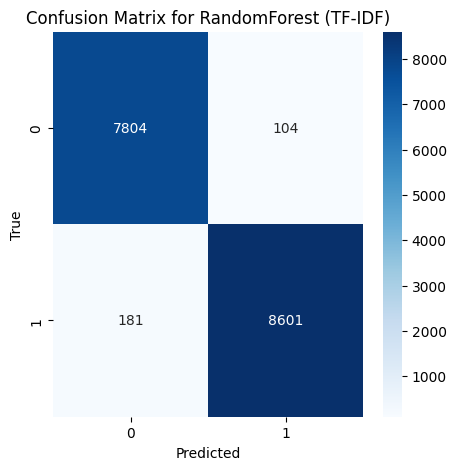

In [19]:
best_rf_tfidf = rf_grid_tfidf.best_estimator_
get_model_metrics(best_rf_tfidf, X_test_tfidf, y_test, "RandomForest (TF-IDF)")

| Model            |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|------------------|------------|-------------|----------|------------|-----------|
| XGBoost (TF-IDF) |     0.9765 |      0.9665 |   0.9895 |     0.9779 |    0.9969 |


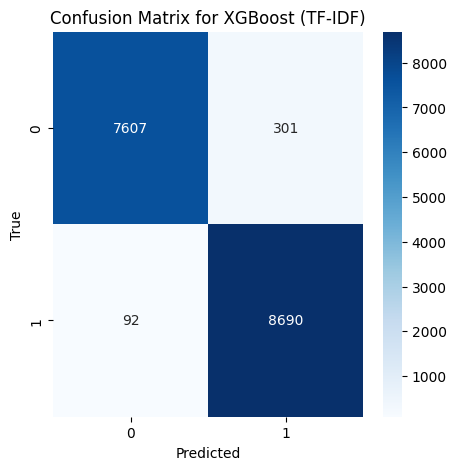

In [20]:
best_xgb_tfidf = xgb_grid_tfidf.best_estimator_
get_model_metrics(best_xgb_tfidf, X_test_tfidf, y_test, "XGBoost (TF-IDF)")

# Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

In [50]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [
    [[1, 0.5], [0.5, 1]],
    [[1, -0.4], [-0.4, 1]],
    [[0.5, 0], [0, 0.75]]
]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
targets = np.zeros(n_samples, dtype=int)

idx = 0
for i, (mean, cov, w) in enumerate(zip(means, covariances, weights)):
    size = int(n_samples * w)
    X[idx:idx+size] = np.random.multivariate_normal(mean, cov, size)
    targets[idx:idx+size] = i
    idx += size

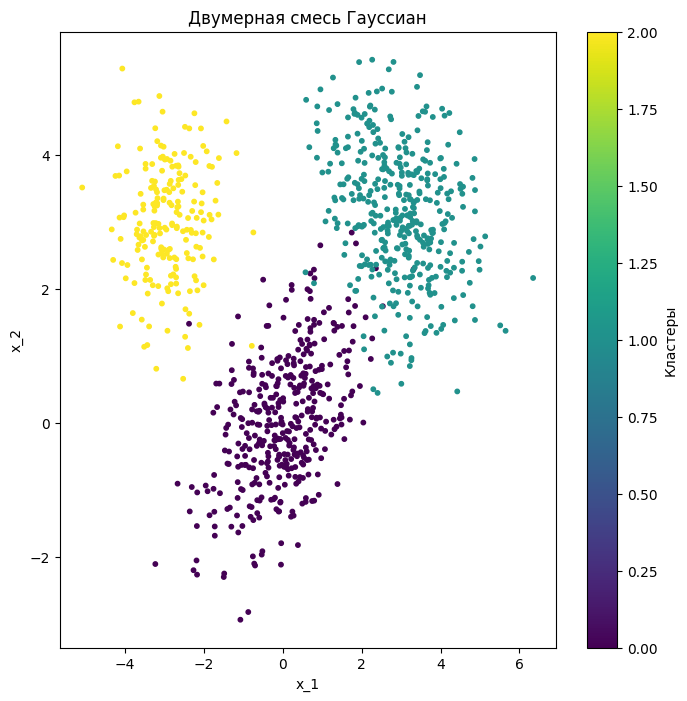

In [51]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=targets, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 10)

silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_k = k_values[np.argmax(silhouette_scores)]

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X)

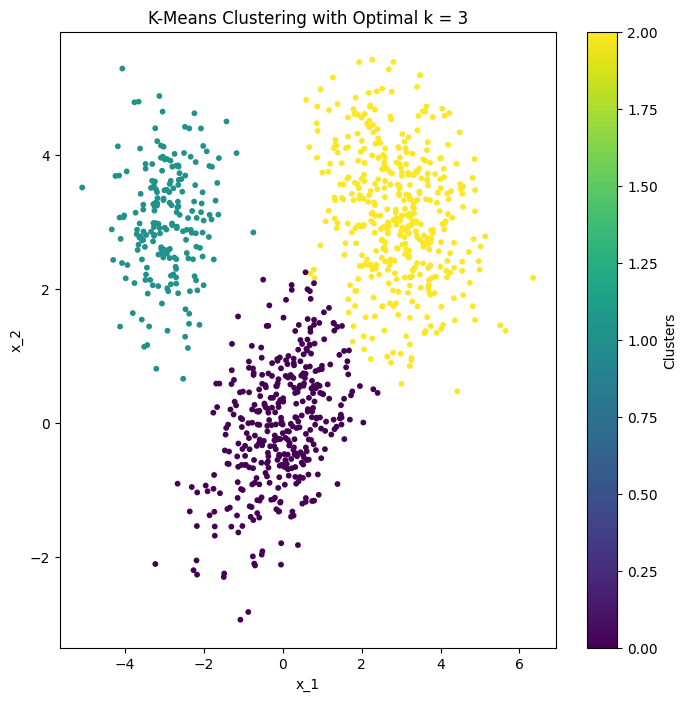

In [53]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_optimal, cmap='viridis', s=10)
plt.title(f"K-Means Clustering with Optimal k = {optimal_k}")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.colorbar(label="Clusters")
plt.show()

In [54]:
print(f"Optimal K: {optimal_k}")
print(f"Silhouette Score for optimal K: {np.max(silhouette_scores)}")

Optimal K: 3
Silhouette Score for optimal K: 0.6063780675401489


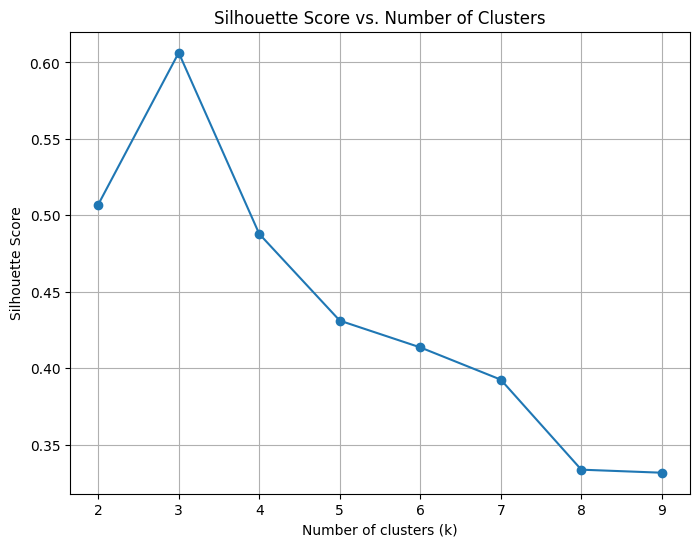

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.show()

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

eps_values = np.linspace(0.5, 2, 10)
min_samples_values = range(2, 10)


best_b_cubed = -1
best_eps = -1
best_min_samples = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X)

        b_cubed = adjusted_rand_score(targets, cluster_labels)

        if b_cubed > best_b_cubed:
            best_b_cubed = b_cubed
            best_eps = eps
            best_min_samples = min_samples

dbscan_optimal = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_labels_optimal = dbscan_optimal.fit_predict(X)

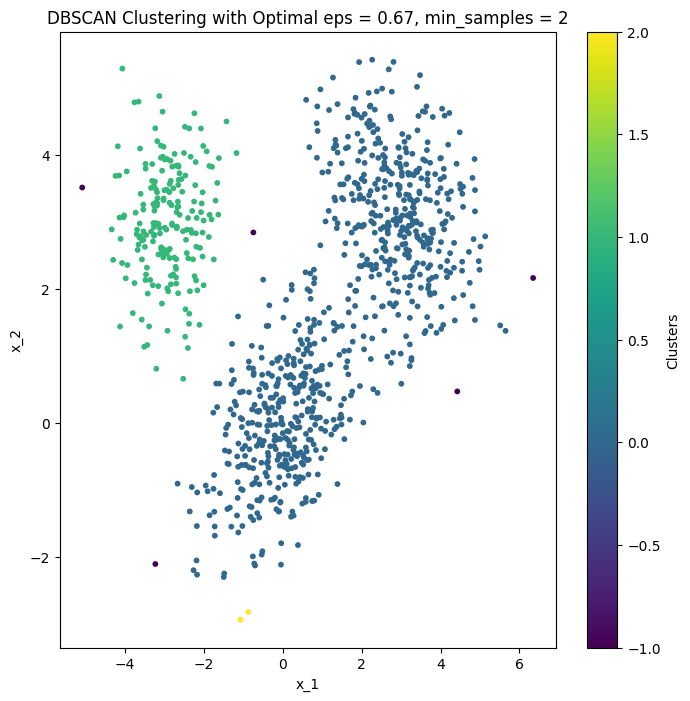

In [57]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_optimal, cmap='viridis', s=10)
plt.title(f"DBSCAN Clustering with Optimal eps = {best_eps:.2f}, min_samples = {best_min_samples}")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.colorbar(label="Clusters")
plt.show()

In [58]:
print(f"Optimal eps: {best_eps:.2f}")
print(f"Optimal min_samples: {best_min_samples}")
print(f"BCubed (ARI) for optimal hyperparameters: {best_b_cubed}")

Optimal eps: 0.67
Optimal min_samples: 2
BCubed (ARI) for optimal hyperparameters: 0.4097686106062381


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

In [59]:
import numpy as np
from scipy.stats import multivariate_normal

def em_gmm(X, n_clusters, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    means = X[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.eye(n_features) for _ in range(n_clusters)]
    weights = np.ones(n_clusters) / n_clusters
    log_likelihoods = []

    for _ in range(max_iter):
        responsibilities = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, means[k], covariances[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        N_k = responsibilities.sum(axis=0)
        weights = N_k / n_samples
        for k in range(n_clusters):
            means[k] = (responsibilities[:, k, None] * X).sum(axis=0) / N_k[k]
            diff = X - means[k]
            covariances[k] = (responsibilities[:, k][:, None] * diff).T.dot(diff) / N_k[k]

        log_probs = [multivariate_normal.logpdf(X, means[k], covariances[k]) for k in range(n_clusters)]
        log_likelihood = np.sum(np.log((responsibilities * np.array(log_probs).T).sum(axis=1)))
        log_likelihoods.append(log_likelihood)

        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    labels = responsibilities.argmax(axis=1)
    return labels, means, covariances, weights

n_clusters = 3
labels_em, means, covariances, weights = em_gmm(X, n_clusters)

C:\Users\vanya\AppData\Local\Temp\ipykernel_21292\3552814557.py:25: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(np.log((responsibilities * np.array(log_probs).T).sum(axis=1)))


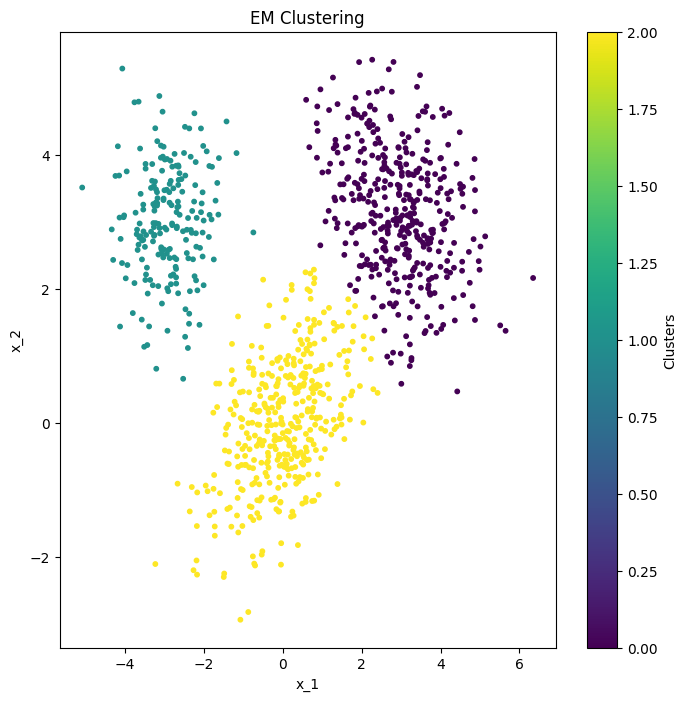

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels_em, cmap='viridis', s=10)
plt.title(f"EM Clustering")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.colorbar(label="Clusters")
plt.show()

In [61]:
ari_em = adjusted_rand_score(targets, labels_em)
print(f"Adjusted Rand Index for EM: {ari_em}")

Adjusted Rand Index for EM: 0.9537371169916434


**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

Gaussian Mixture Model (GMM) — вероятностная модель, считающая, что данные получены из смеси нескольких гауссовских распределений. Каждое из этих распределений соответствует отдельному кластеру. Задача GMM — подобрать параметры (средние значения, ковариационные матрицы и пропорции смеси), которые наилучшим образом описывают структуру данных.

Для оценивания параметров обычно применяется алгоритм ожидания-максимизации (EM). На E-шаге вычисляются вероятности принадлежности каждой точки к каждому гауссовскому компоненту. На M-шаге параметры компонентов пересчитываются с учётом полученных вероятностей. Эти шаги чередуются до сходимости. В итоге GMM определяет, к какому кластеру относится каждая точка, исходя из максимальной вероятности её принадлежности.

In [62]:
from sklearn.mixture import GaussianMixture


gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

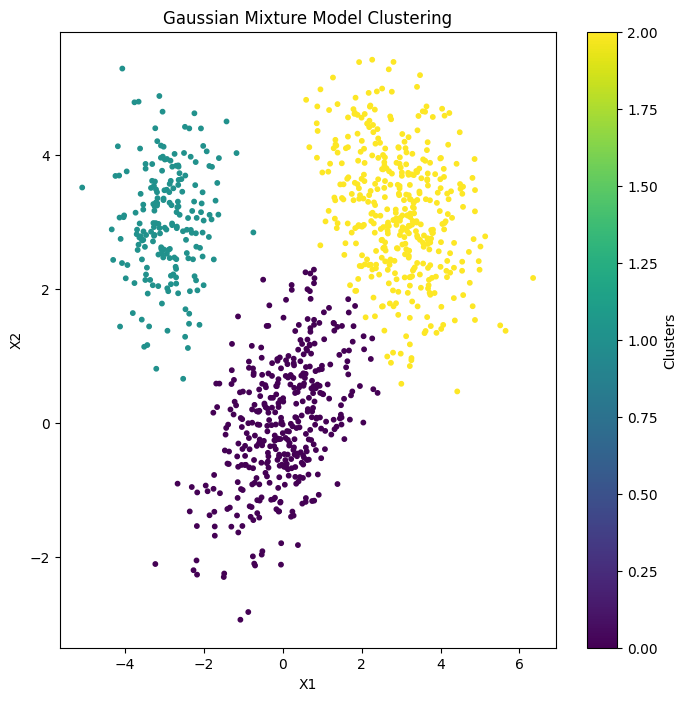

In [63]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Gaussian Mixture Model Clustering")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.colorbar(label="Clusters")
plt.show()

In [64]:
ari_gmm = adjusted_rand_score(targets, gmm_labels)
print(f"Adjusted Rand Index for GMM: {ari_gmm}")

Adjusted Rand Index for GMM: 0.9503761618397394
